## Introduction

SpaceX has gained worldwide attention for a series of historic milestones.

It is the only private company ever to return a spacecraft from low-earth orbit, which it first accomplished in December 2010. 

SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. 

Therefore if we can determine if the first stage will land, we can determine the cost of a launch. 

This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.
aunch.

## Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime,time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)

## Data Collection

In [2]:
# Fetch SpaceX launch data from the API
spacex_url="https://api.spacexdata.com/v4/launches/past"
response=requests.get(spacex_url)
response.status_code

200

In [3]:
# Convert json to pandas dataframe
data=pd.json_normalize(response.json())
data.head(1)

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN


In [4]:
data.shape

(187, 43)

In [5]:
data.columns

Index(['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window',
       'rocket', 'success', 'failures', 'details', 'crew', 'ships', 'capsules',
       'payloads', 'launchpad', 'flight_number', 'name', 'date_utc',
       'date_unix', 'date_local', 'date_precision', 'upcoming', 'cores',
       'auto_update', 'tbd', 'launch_library_id', 'id', 'fairings.reused',
       'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships',
       'links.patch.small', 'links.patch.large', 'links.reddit.campaign',
       'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery',
       'links.flickr.small', 'links.flickr.original', 'links.presskit',
       'links.webcast', 'links.youtube_id', 'links.article', 'links.wikipedia',
       'fairings'],
      dtype='object')

In [6]:
# Select relevant columns for analysis
data=data[['rocket','payloads', 'launchpad', 'flight_number','date_utc','cores']]
data.rocket.value_counts()

rocket
5e9d0d95eda69973a809d1ec    179
5e9d0d95eda69955f709d1eb      5
5e9d0d95eda69974db09d1ed      3
Name: count, dtype: int64

In [7]:
# Remove rows with multiple payloads and cores
data=data[data.payloads.map(len)==1]
data=data[data.cores.map(len)==1]

# Extract payloads and cores value from list
data.payloads=data.payloads.map(lambda x:x[0])
data.cores=data.cores.map(lambda x:x[0])

In [8]:
data.launchpad.value_counts()

launchpad
5e9e4501f509094ba4566f84    93
5e9e4502f509094188566f88    49
5e9e4502f509092b78566f87    26
5e9e4502f5090995de566f86     4
Name: count, dtype: int64

In [9]:
# Convert date_utc to datetime datatype and extracting only date
data['date']=pd.to_datetime(data.date_utc).dt.date

# Restrict date of launch upto 2022
data=data[data['date']<datetime.date(2023,1,1)]

# Get list of rocket name for each record by rocket id
rocket_name_dict={}

for rocket in data['rocket'].unique():
    rocket_name_dict[rocket]=requests.get('https://api.spacexdata.com/v4/rockets/'+str(rocket)).json()['name']

BoosterVersion=list(data['rocket'].map(rocket_name_dict))

# Get list of LaunchSite,Longitude & Latitude for each record by launchpad id
lp_launchsite_dict,lp_longitude_dict,lp_latitude_dict={},{},{}

for launchpad in data['launchpad'].unique():
    response=requests.get('https://api.spacexdata.com/v4/launchpads/'+str(launchpad)).json()
    lp_launchsite_dict[launchpad]=response['name']
    lp_longitude_dict[launchpad]=response['longitude']
    lp_latitude_dict[launchpad]=response['latitude']

LaunchSite=list(data['launchpad'].map(lp_launchsite_dict))
Longitude=list(data['launchpad'].map(lp_longitude_dict))
Latitude=list(data['launchpad'].map(lp_latitude_dict))

# Get list of mass & orbit of payload for each record by payload id
response=requests.get('https://api.spacexdata.com/v4/payloads/').json()
payload_mass_dict,payload_orbit_dict={},{}

for payload_id in data['payloads'].unique():
    for dict in response:
        if payload_id==dict['id']:
            payload_mass_dict[payload_id]=dict['mass_kg']
            payload_orbit_dict[payload_id]=dict['orbit']
            break

PayloadMass=list(data['payloads'].map(payload_mass_dict))
Orbit=list(data['payloads'].map(payload_orbit_dict))

# Get list of core data for each record by cores id
response=requests.get('https://api.spacexdata.com/v4/cores/').json()
Block_dict,ReusedCount_dict,Serial_dict={},{},{}

for core_id in set(data['cores'].apply(lambda x:x['core'])):
    for dict in response:
        if core_id==dict['id']:
            Block_dict[core_id]=dict['block']
            ReusedCount_dict[core_id]=dict['reuse_count']
            Serial_dict[core_id]=dict['serial']
            break

Block=data['cores'].apply(lambda x: x['core']).map(Block_dict)
ReusedCount=data['cores'].apply(lambda x: x['core']).map(ReusedCount_dict)
Serial=data['cores'].apply(lambda x: x['core']).map(Serial_dict)

Outcome,Flights,GridFins,Reused,Legs,LandingPad=[],[],[],[],[],[]   
for x in data['cores']:
    Outcome.append(str(x['landing_success'])+' '+str(x['landing_type']))
    Flights.append(x['flight'])
    GridFins.append(x['gridfins'])
    Reused.append(x['reused'])
    Legs.append(x['legs'])
    LandingPad.append(x['landpad'])

In [10]:
# Create a dictionary to store launch data
launch_dict={'FlightNumber':list(data['flight_number']),
            'Date':list(data['date']),
            'BoosterVersion':BoosterVersion,
            'PayloadMass':PayloadMass,
            'Orbit':Orbit,
            'LaunchSite':LaunchSite,
            'Outcome':Outcome,
            'Flights':Flights,
            'GridFins':GridFins,
            'Reused':Reused,
            'Legs':Legs,
            'LandingPad':LandingPad,
            'Block':Block,
            'ReusedCount':ReusedCount,
            'Serial':Serial,
            'Longitude': Longitude,
            'Latitude': Latitude}

# Create a DataFrame from the launch_dict
df=pd.DataFrame(launch_dict)

df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
3,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
4,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
5,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [11]:
df.BoosterVersion.value_counts()

BoosterVersion
Falcon 9    168
Falcon 1      4
Name: count, dtype: int64

In [12]:
# Filtering BoosterVersion to only include Falcon 9
data_falcon9=df[df['BoosterVersion']=='Falcon 9']
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
5,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
7,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
9,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
10,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
11,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [13]:
# Reset FlightNumber column
data_falcon9.loc[:,'FlightNumber']=list(range(1,data_falcon9.shape[0]+1))

In [14]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass       22
Orbit              1
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [15]:
# Replace missing PayloadMass with mean value
pl_mass_mean=data_falcon9.PayloadMass.mean()
data_falcon9.PayloadMass.replace(np.nan,pl_mass_mean,inplace=True)

data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
5,1,2010-06-04,Falcon 9,8191.07911,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
7,2,2012-05-22,Falcon 9,525.00000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
9,3,2013-03-01,Falcon 9,677.00000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
10,4,2013-09-29,Falcon 9,500.00000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
11,5,2013-12-03,Falcon 9,3170.00000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [16]:
# Export data_falcon9 to csv
data_falcon9.to_csv('dataset_part_1.csv',index=False)

## Data Wrangling

In [17]:
# load SpaceX dataset that was collected by API
df=pd.read_csv('dataset_part_1.csv')

# Percentage of missing value in each attribute
df.isnull().sum()/len(df)*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.595238
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        15.476190
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [18]:
# Records where orbit value is null
df[df.Orbit.isna()]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
95,96,2020-12-19,Falcon 9,8191.07911,NaN,KSC LC 39A,True RTLS,5,True,True,True,5e9e3032383ecb267a34e7c7,5.0,5,B1059,-80.603956,28.608058


In [19]:
# Data types of each attribute
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [20]:
# No. of lauches on each site
df.LaunchSite.value_counts()

LaunchSite
CCSFS SLC 40    93
KSC LC 39A      49
VAFB SLC 4E     26
Name: count, dtype: int64

In [21]:
# Occurence of each orbit
df.Orbit.value_counts()

Orbit
VLEO     54
ISS      32
GTO      31
LEO      14
PO       13
SSO      11
MEO       5
GEO       2
TLI       2
ES-L1     1
HEO       1
SO        1
Name: count, dtype: int64

In [22]:
# Occurence of mission outcome
df.Outcome.value_counts()

Outcome
True ASDS      109
True RTLS       23
None None       19
False ASDS       7
True Ocean       5
False Ocean      2
None ASDS        2
False RTLS       1
Name: count, dtype: int64

True/False Ocean: Successful/Unsuccessful landing in Ocean  
True/False RTLS: Suceessful/Unsuccessful landing to ground pad  
True/False ASDS: Successful/Unsuccessful landing to drone ship  
None ASDS or None None: Fail to land

In [23]:
# Create bad outcome list (where landing was unsuccessful)
bad_outcomes=df.Outcome.value_counts().keys()[[2,3,5,6,7]]

# Create landing class label using Outcome column
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise

landing_class=[0 if outcome in bad_outcomes else 1 for outcome in df.Outcome]

In [24]:
# Occurence of landing outcome as success(1) and failure(0)
pd.Series(landing_class).value_counts()

1    137
0     31
Name: count, dtype: int64

In [25]:
# Add Class feature in df as outcome of each launch
df['Class']=landing_class

df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,8191.07911,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.00000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.00000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.00000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.00000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
5,6,2014-01-06,Falcon 9,3325.00000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857,0
6,7,2014-04-18,Falcon 9,2296.00000,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857,1
7,8,2014-07-14,Falcon 9,1316.00000,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857,1
8,9,2014-08-05,Falcon 9,4535.00000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857,0
9,10,2014-09-07,Falcon 9,4428.00000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857,0


In [26]:
# Success rate
df.Class.mean()

0.8154761904761905

In [27]:
# Export the cleaned dataset
df.to_csv('dataset_part_2.csv',index=False)

## EDA by visualization

In [28]:
# Load the cleaned dataset for visualization
df=pd.read_csv('dataset_part_2.csv')
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,8191.07911,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.00000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.00000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.00000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.00000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


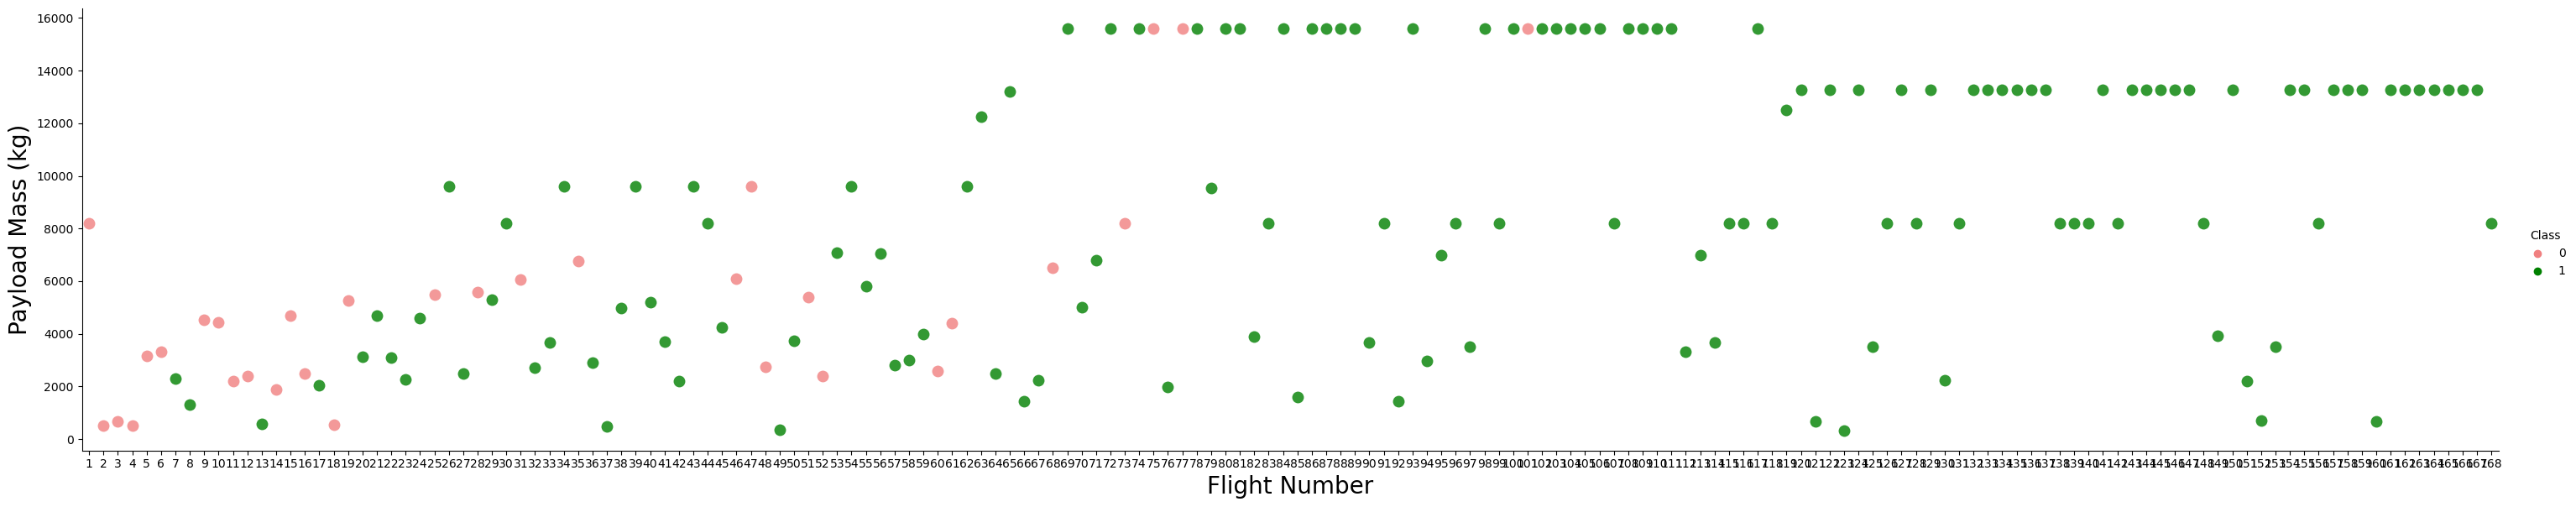

In [29]:
# Plotting FlightNumber vs. PayloadMass wih Outcomes
sns.catplot(data=df,x='FlightNumber',y='PayloadMass',hue='Class',palette={0:'lightcoral',1:'green'},s=100,alpha=0.8,height=6,aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Payload Mass (kg)",fontsize=20)
plt.show()

**As the flight number increases, it's more likely to land successfully.**

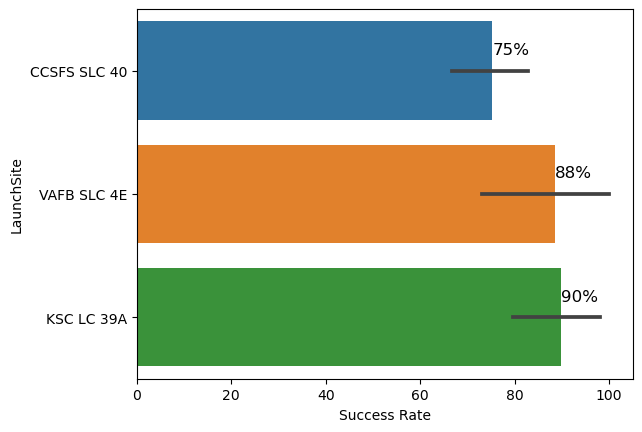

In [30]:
# Plotting Success Rate of Launch Sites
ax=sns.barplot(y=df.LaunchSite,x=df.Class*100)
plt.xlabel('Success Rate')
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}%',(p.get_width(),p.get_y()+p.get_height()/3),fontsize=12)
plt.show()

**We see that different launch sites have different success rates.**  

**`CCAFS LC-40`, has a success rate of 75 %,   
while `VAFB SLC 4E` and `KSC LC-39A` has a success rate of 88% and 90% respectively.**

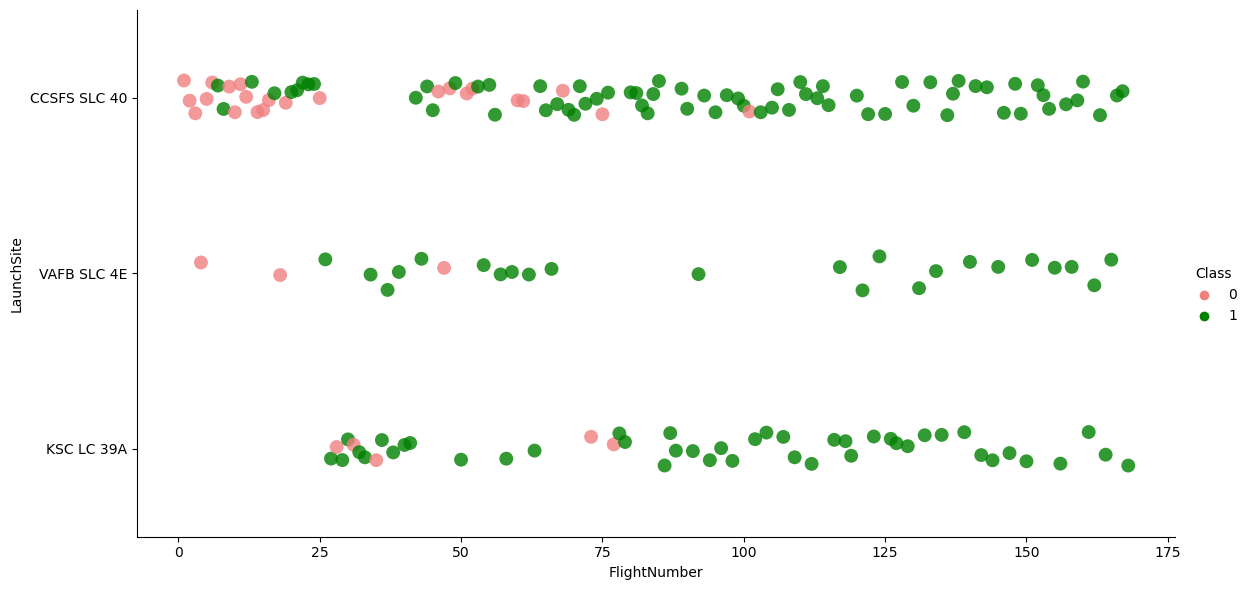

In [31]:
# Relationship b/w Flight Number and Launch Site
sns.catplot(df,x='FlightNumber',y='LaunchSite',hue='Class',palette={0:'lightcoral',1:'green'},s=100,alpha=0.8,height=6, aspect=2)
plt.show()

**The launch site `KSCKC 39A` was first used after the 25th flight.**  

**There is a higher launch frequency   
for `CCAFS SLC-40` with flight numbers between 1-25 and above 40, and   
for `KSCKC 39A` between flight numbers 25-40.**  

**There is a positive trend in the success rate with increasing flight numbers.**

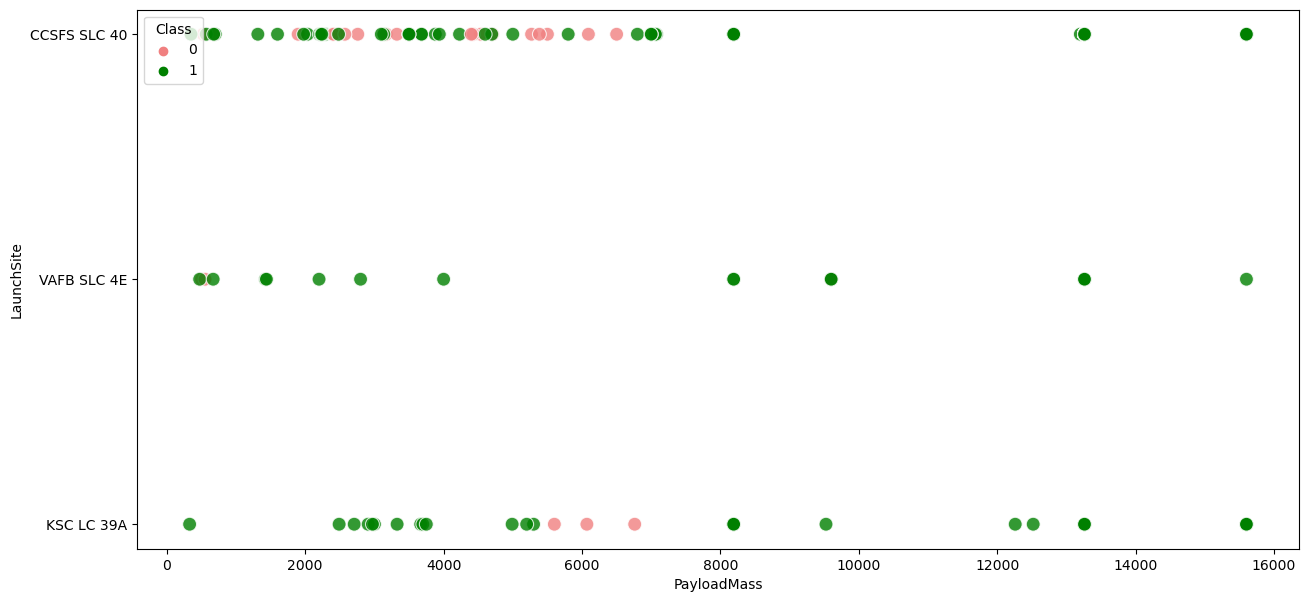

In [32]:
# Relationship b/w Payload and Launch Site
plt.figure(figsize=(15,7))
sns.scatterplot(x=df.PayloadMass,y=df.LaunchSite,hue=df.Class,palette={0:'lightcoral',1:'green'},s=100,alpha=0.8)
plt.show()

**Only few rockets launched for heavypayload mass(greater than 10000).  
`VAFB-SLC` launchsite is least used.**

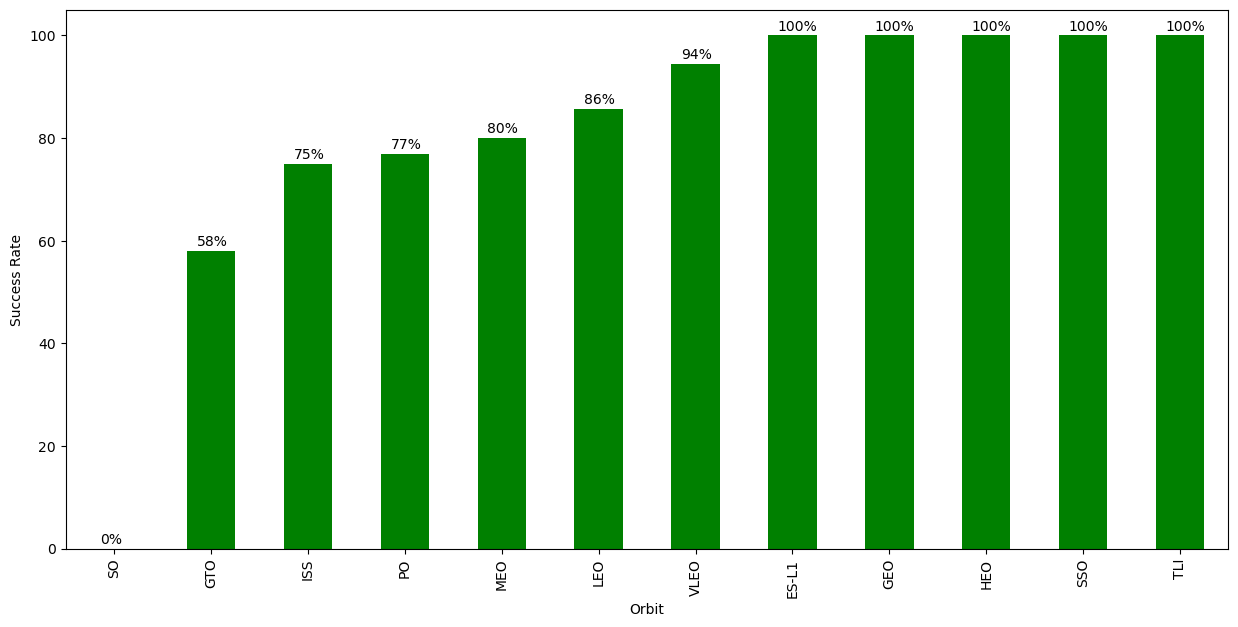

In [33]:
# Success rate of each orbit type
plt.figure(figsize=(15,7))
grouped=(df.groupby('Orbit')['Class'].mean()*100).sort_values()
ax=grouped.plot(kind='bar',color='g')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%',(p.get_x()+p.get_width()/5,p.get_height()+1))
plt.ylabel('Success Rate')
plt.show()

**Flights went to orbit type `ES-L1`, `GEO`, `HEO` , `SSO` & `TU` have highest success rate with 100%.  
And with orbit type `SO` has least success rate with 0%.**

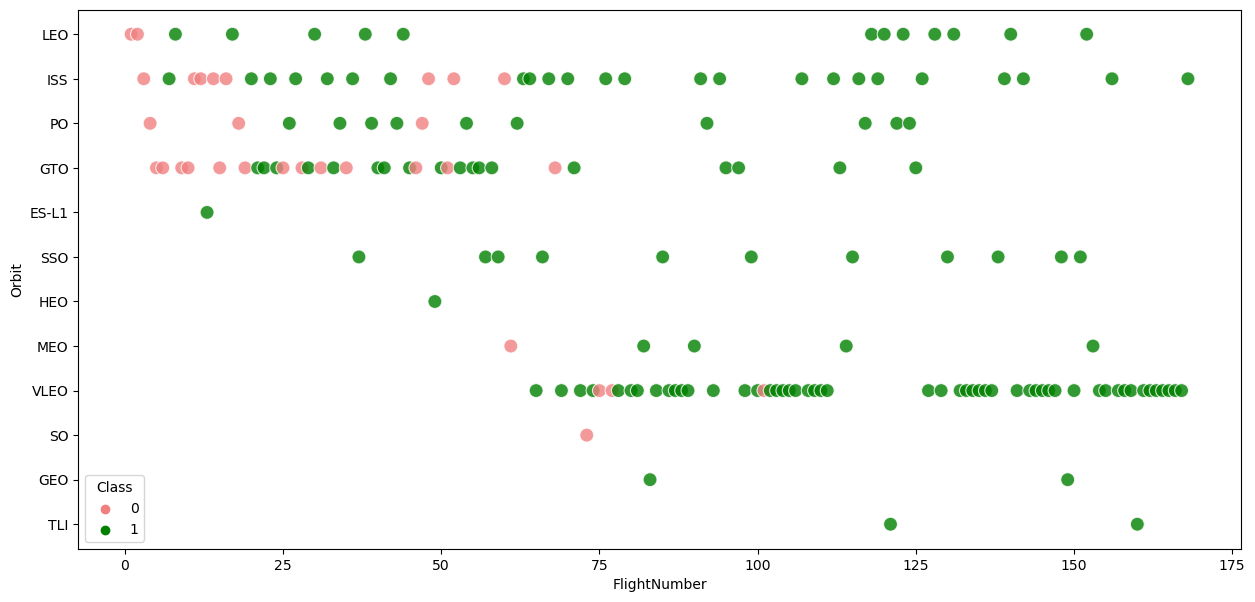

In [34]:
# Relationship between the flight number and orbit type
plt.figure(figsize=(15,7))
sns.scatterplot(x=df.FlightNumber,y=df.Orbit,hue=df.Class,palette={0:'lightcoral',1:'green'},s=100,alpha=0.8)
plt.show()

**For `LEO`, `VLEO` & `ISS` orbit, the Success appears related to the number of flights;   
And, there seems to be no relationship between flight number when in `GTO` orbit.**

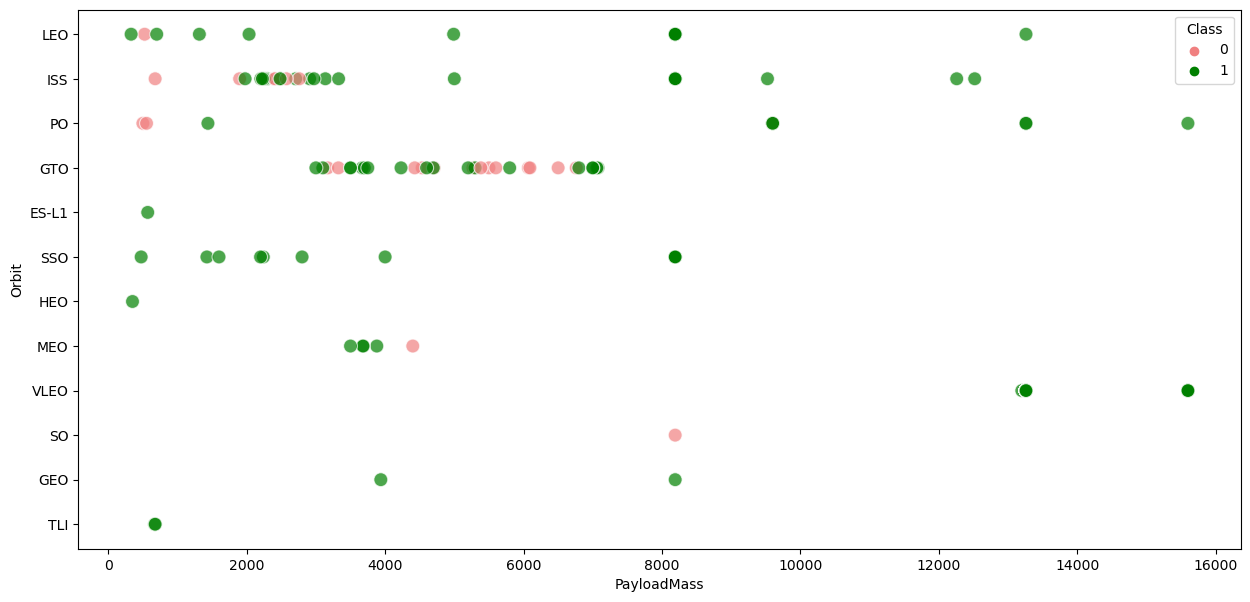

In [35]:
# Relationship between payload and orbit type
plt.figure(figsize=(15,7))
sns.scatterplot(x=df.PayloadMass,y=df.Orbit,hue=df.Class,palette={0:'lightcoral',1:'green'},s=100,alpha=0.7)
plt.show()

**With heavy payloads (above 6000kg) the successful landing or positive landing rate are more for `Polar`, `LEO`, `VLEO` and `ISS`.**    

**However for `GTO` we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.**


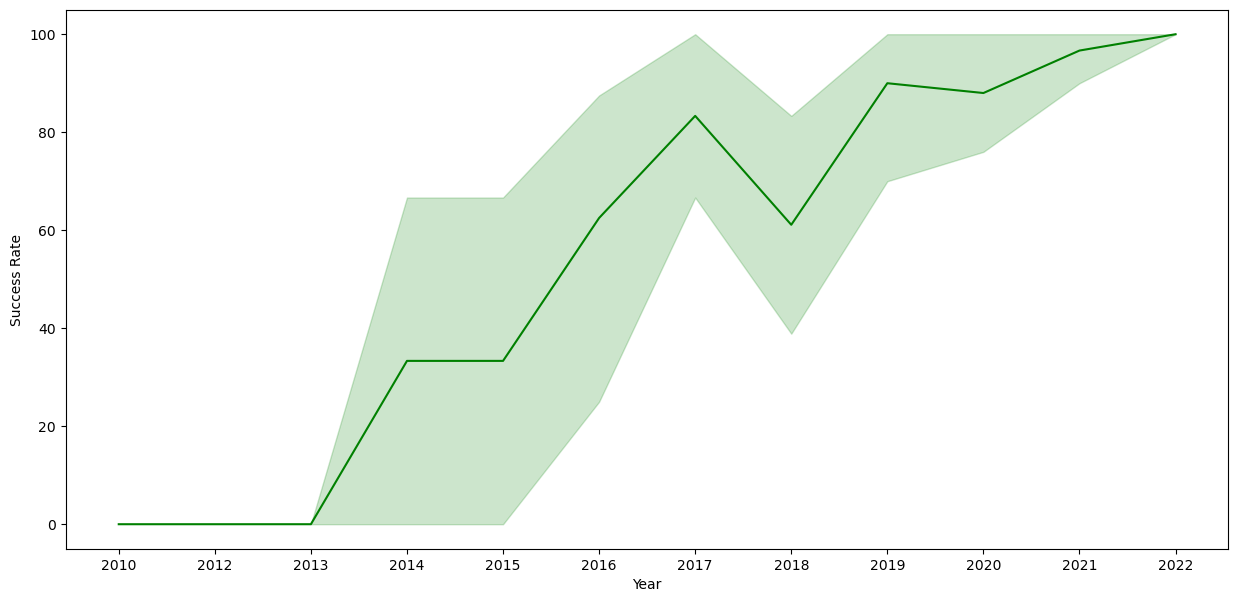

In [36]:
# Yearly trend of success rate
def Extract_year():
    year=[]
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year

df1=df.copy()
df1['Year']=Extract_year()

plt.figure(figsize=(15,7))
sns.lineplot(x=df1.Year,y=df1.Class*100,c='g')
plt.ylabel('Success Rate')
plt.show()

**1. The success rate has been consistently increasing since 2013.  
2. It remained stable in 2014.  
3. In 2015, there was a renewed increase.  
4. A drop was observed in 2018.  
5. Success rates started increasing once more, with a minor dip in 2020.**

**Feature Engineering**

In [37]:
df.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude',
       'Class'],
      dtype='object')

In [38]:
# Selecting the features that will be used in success prediction
features=df[['FlightNumber','PayloadMass', 'Orbit','LaunchSite','Flights', 'GridFins', 'Reused', 'Legs','LandingPad', 'Block', 'ReusedCount', 'Serial']]
features

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,8191.07911,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.00000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.00000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.00000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.00000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004
...,...,...,...,...,...,...,...,...,...,...,...,...
163,164,13260.00000,VLEO,KSC LC 39A,2,True,True,True,5e9e3033383ecb075134e7cd,5.0,1,B1069
164,165,13260.00000,VLEO,VAFB SLC 4E,7,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,6,B1063
165,166,13260.00000,VLEO,CCSFS SLC 40,6,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,5,B1067
166,167,13260.00000,VLEO,CCSFS SLC 40,4,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,0,B1072


In [39]:
# Creating dummy variables to categorical columns for One-Hot Encoding
features_one_hot=pd.get_dummies(features)
features_one_hot

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecb075134e7cd,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1052,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1072,Serial_B1073,Serial_B1077
0,1,8191.07911,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,525.00000,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,677.00000,1,False,False,False,1.0,0,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,500.00000,1,False,False,False,1.0,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5,3170.00000,1,False,False,False,1.0,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,..

In [40]:
# Casting all numeric columns to float data type
features_one_hot=features_one_hot.astype(float)
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1069    float64
Serial_B1071    float64
Serial_B1072    float64
Serial_B1073    float64
Serial_B1077    float64
Length: 91, dtype: object

In [41]:
features_one_hot.to_csv('dataset_part_3.csv',index=False)

## EDA by SQL

In [42]:
# Importing libraries for database operations
import sqlalchemy,sqlite3
%load_ext sql

In [43]:
# Create a connection to the SQLite database using SQLAlchemy and store the connection object in the 'engine' variable
engine = sqlalchemy.create_engine('sqlite:///my_data1.db')

# Read data from a CSV file 'Spacex.csv' and store it in the DataFrame 'df'
df = pd.read_csv("Spacex.csv")

# Write the DataFrame 'df' to the SQLite database as a table named 'SPACEXTABLE'
df.to_sql('SPACEXTABLE', con=engine, if_exists='replace', index=False, method='multi')

# Sets the connection string for the %sql magic command, connecting to SQLite database 'my_data1.db'
%sql sqlite:///my_data1.db

**'%sql'---Single-Line SQL Magic  (can be used for multi line by using '\\'  
'%%sql'---Multi-Line SQL Magic**

In [44]:
%sql select * from SPACEXTABLE limit 10

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-04-06,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-08-12,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-08-10,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-01-03,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt
2013-09-29,16:00:00,F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500,Polar LEO,MDA,Success,Uncontrolled (ocean)
2013-03-12,22:41:00,F9 v1.1,CCAFS LC-40,SES-8,3170,GTO,SES,Success,No attempt
2014-06-01,22:06:00,F9 v1.1,CCAFS LC-40,Thaicom 6,3325,GTO,Thaicom,Success,No attempt
2014-04-18,19:25:00,F9 v1.1,CCAFS LC-40,SpaceX CRS-3,2296,LEO (ISS),NASA (CRS),Success,Controlled (ocean)
2014-07-14,15:15:00,F9 v1.1,CCAFS LC-40,OG2 Mission 1 6 Orbcomm-OG2 satellites,1316,LEO,Orbcomm,Success,Controlled (ocean)


In [45]:
# Checking empty date record
%sql select * from SPACEXTABLE where date is null

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome


In [46]:
# Unique launch sites in the space mission
%sql select distinct launch_site from spacextable

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


In [47]:
# Records with Launch sites 'CCAFS'

In [48]:
%%sql 
select * from SPACEXTABLE 
where launch_site like 'CCAFS%'
limit 5

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-04-06,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-08-12,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-08-10,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-01-03,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


In [50]:
# Total payload mass carried by boosters launched by NASA's Commercial Resupply Services (CRS)
%sql \
select sum(PAYLOAD_MASS__KG_) \
from spacextable \
where customer = 'NASA (CRS)'

 * sqlite:///my_data1.db
Done.


sum(PAYLOAD_MASS__KG_)
45596


In [51]:
# Avg. payload mass carried by booster version F9 v1.1
%sql \
select avg(payload_mass__kg_) \
from spacextable \
where booster_version = 'F9 v1.1'

 * sqlite:///my_data1.db
Done.


avg(payload_mass__kg_)
2928.4


In [52]:
# Date of first succesful landing outcome in ground pad
%sql \
select min(date) from spacextable \
where landing_outcome = 'Success (ground pad)'

 * sqlite:///my_data1.db
Done.


min(date)
2015-12-22


In [53]:
# Boosters which have success in drone ship and have payload mass in range 4000 to 6000 kg
%sql \
select booster_version from spacextable \
where landing_outcome = 'Success (drone ship)' and\
      payload_mass__kg_ > 4000 and\
      payload_mass__kg_ < 6000

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


In [54]:
# Total number of successful and failure mission outcomes
%sql \
select  mission_outcome,count(*) 'Total_No.' \
from spacextable \
group by mission_outcome

 * sqlite:///my_data1.db
Done.


Mission_Outcome,Total_No.
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


In [55]:
# Booster_versions which have carried the maximum payload mass
%sql \
select distinct booster_version \
from spacextable \
where payload_mass__kg_= \
        (select max(payload_mass__kg_) \
         from spacextable)

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


In [56]:
# Detail of failure landing_outcomes in drone ship for year 2015
%sql \
select substr(date,6,2) 'Month',date,landing_outcome,booster_version,launch_site \
from spacextable \
where substr(date,1,4)='2015' \
and landing_outcome='Failure (drone ship)'

 * sqlite:///my_data1.db
Done.


Month,Date,Landing_Outcome,Booster_Version,Launch_Site
10,2015-10-01,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
04,2015-04-14,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40


In [57]:
# Rank the count of landing outcomes between the date 2010-01-01 and 2023-01-01, in descending order.
%sql \
select landing_outcome, \
    count(landing_outcome) 'Count' \
from spacextable \
where date between '2010-01-01' and '2023-01-01' \
group by landing_outcome \
order by 2 desc

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Count
Success,38
No attempt,21
Success (drone ship),14
Success (ground pad),9
Failure (drone ship),5
Controlled (ocean),5
Failure,3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


## Folium

In [58]:
import folium
from folium.plugins import MarkerCluster, MousePosition
from folium.features import DivIcon

In [59]:
# Read data from a CSV file 'spacex_launch_geo.csv'
spacex_df=pd.read_csv('spacex_launch_geo.csv')
spacex_df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouère cheese",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


In [60]:
# Selecting relevant columns: 'Launch Site','Lat','Long','Class'
spacex_df=spacex_df[['Launch Site','Lat','Long','class']]
spacex_df.head()

,Launch Site,Lat,Long,class
0,CCAFS LC-40,28.562302,-80.577356,0
1,CCAFS LC-40,28.562302,-80.577356,0
2,CCAFS LC-40,28.562302,-80.577356,0
3,CCAFS LC-40,28.562302,-80.577356,0
4,CCAFS LC-40,28.562302,-80.577356,0


In [61]:
# Unique launch site
launch_sites_df=spacex_df.groupby(['Launch Site'],as_index=False).first()
launch_sites_df

,Launch Site,Lat,Long,class
0,CCAFS LC-40,28.562302,-80.577356,0
1,CCAFS SLC-40,28.563197,-80.576820,1
2,KSC LC-39A,28.573255,-80.646895,1
3,VAFB SLC-4E,34.632834,-120.610745,0


In [62]:
# Extracting relevant columns
launch_sites_df=launch_sites_df[['Launch Site','Lat','Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [63]:
# Creating folium map object 'site_map', with center 'NASA Johnson Space Center, Houston, Texas'
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map=folium.Map(location=nasa_coordinate, zoom_start=10)
site_map

In [64]:
# Creating a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle=folium.Circle(nasa_coordinate,radius=1000,color='blue',fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
circle.add_to(site_map)

# Create a blue icon of 'NASA JSC' at NASA Johnson Space Center's coordinate
marker=folium.Marker(nasa_coordinate,
                     icon=DivIcon(icon_size=(20,20),
                                  icon_anchor=(0,0),
                                  html='<div style="font-size: 13px;color: blue;"><b>%s</b></div>'%'NASA JSC'
                                 )
                    )
marker.add_to(site_map)

**Marking all launch sites on a map**

In [65]:
for index,row in launch_sites_df.iterrows():

    site_coord=[row.Lat,row.Long]
    
    # adding a darkviolet circle at each launch site with a popup as its name
    circle=folium.Circle(site_coord,
                  radius=1000,
                  color='darkviolet',
                  fill=True
                 ).add_child(folium.Popup(row['Launch Site']))
    circle.add_to(site_map)
    
    # adding a darkviolet icon of launch site name at its coordinate
    marker=folium.Marker(site_coord,
                         icon=DivIcon(icon_size=(20,20),
                                      icon_anchor=(0,0),
                                      html='<div style="font-size: 13px;color: darkviolet;"><b>%s</b></div>'%row['Launch Site']
                                     )
                        )
    marker.add_to(site_map)

# Adding equator line
folium.PolyLine(locations=[[0,-180],[0,180]],color='black').add_to(site_map)    

site_map

In [66]:
# Getting marker colors based on the 'class' column
def marker_color(Class):
    if Class==0:
        return 'red'
    else:
        return 'green'

spacex_df['marker_color']=spacex_df['class'].apply(marker_color)

spacex_df.head()

,Launch Site,Lat,Long,class,marker_color
0,CCAFS LC-40,28.562302,-80.577356,0,red
1,CCAFS LC-40,28.562302,-80.577356,0,red
2,CCAFS LC-40,28.562302,-80.577356,0,red
3,CCAFS LC-40,28.562302,-80.577356,0,red
4,CCAFS LC-40,28.562302,-80.577356,0,red


**Marking the success/failed launches for each site on the map**

In [67]:
marker_cluster=MarkerCluster()
site_map.add_child(marker_cluster)

for _,row in spacex_df.iterrows():
    coord=[row.Lat,row.Long]
    marker=folium.Marker(coord,
                         icon=folium.Icon(color='white',
                                          icon_color=row.marker_color)
                        )
    marker.add_to(marker_cluster)

site_map

In [68]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
mouse_position=MousePosition(position='topright',
                             empty_string='NaN',
                             prefix='Lat:',
                             separator=' Long:')
site_map.add_child(mouse_position)

**Calculating the distances between a launch site to its proximities**

 **Haversine Formula**  
   
   The Haversine formula is a mathematical formula used to calculate the distance between two points on the surface of a sphere, such as the Earth. It's particularly useful for determining the great-circle distance (the shortest distance over the Earth's surface) between two coordinates specified in terms of latitude and longitude.  

     The formula is named after the haversine function, which is used in the calculation. 
  
  
  
1. Calculate $a$:  
- $a=\sqrt{hav(\Delta\phi)+cos\phi_1*cos\phi_2*hav(\Delta\lambda)}$  
where  
- $hav(x)=\text{haversine of }x=\sin^2(\frac{x}{2})$
- $\phi_1,\phi_2=latitude_1,latitude_2$  
- $\lambda_1,\lambda_2=longitude_1,longitude_2$  
  
- $\Delta\phi=latitude_1-latitude_2$  
- $\Delta\lambda=longitude_1-longitude_2$

  
2. Calculate $\theta$:  
- $\theta=2*\sin^{-1}(\sqrt{a})$  
or   
- $\theta=2*\tan^{-1}(\frac {\sqrt{a}}{\sqrt{1-a}})$  


 $l = r * \theta$  

In [69]:
from math import sin,cos,atan2,sqrt,radians

# calculate the distance between two points on the map based on their Lat and Long values
def calc_distance(lat1,long1,lat2,long2):

    r=6371 # Earth's mean radius in KM

    # Convert latitude and longitude from degrees to radians
    lat1=radians(lat1)
    lat2=radians(lat2)
    long1=radians(long1)
    long2=radians(long2)

    # Calculate the differences in latitude and longitude
    dlat=lat2-lat1
    dlong=long2-long1
    
    a=sin(dlat/2)**2+cos(lat1)*cos(lat2)*sin(dlong/2)**2
    c=2*atan2(sqrt(a),sqrt(1-a))

    return r*c # returns the distance

In [70]:
# Showing proximities distance from launch site KSC LC-39A
launch_site_lat,launch_site_lon=28.57238,-80.64678
launchsite_coord=[launch_site_lat,launch_site_lon]

dist_marker_cluster=MarkerCluster()
site_map.add_child(dist_marker_cluster)

for proximity in [{'loc':'Coastline','lat':28.58024,'lon':-80.64210},
                  {'loc':'Rail','lat':28.57300,'lon':-80.65392},
                  {'loc':'City','lat':28.61200,'lon':-80.80799},
                  {'loc':'Highway','lat':28.57346,'lon':-80.65548}
                 ]:
    
    dist= calc_distance(launch_site_lat,launch_site_lon,
                                 proximity['lat'],proximity['lon']
                                )
    dist_marker = folium.Marker([proximity['lat'],proximity['lon']],
                                icon=DivIcon(icon_size=(20,20),
                                             icon_anchor=(0,0),
                                             html='<div style="font-size: 12px; color:blue;"><b>%s</b></div>' % "{} at {:.2f} KM".format(proximity['loc'],
                                                                                                                                         dist)
                                            )
                               )
    dist_marker_cluster.add_child(dist_marker)

    line=folium.PolyLine(locations=[launchsite_coord,[proximity['lat'],proximity['lon']]], weight=1,color='blue')
    site_map.add_child(line)
site_map    

**- Launch sites near railways and highways simplify transportation of equipment and personnel.**  
**- Launch sites near coastlines offer a safe area for rocket stages to land after separation.**  
**- Keeping launch sites at a distance from cities minimizes risks to people and property, particularly in case of launch failures or falling debris.**


## Dash

In [71]:
# Import required libraries
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

# Read the SpaceX launch data into a pandas dataframe
spacex_df = pd.read_csv("spacex_launch_dash.csv")

# Calculate the maximum and minimum payload mass
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

# Create a dash application
app = dash.Dash(__name__)

# Layout of application
app.layout = html.Div(children=
                      [html.H1('SpaceX Launch Records Dashboard',
                               style={'textAlign': 'center',
                                      'color': 'brown',
                                      'font-size': 40}
                              ),
                       
                       # Dropdown menu to select a launch site
                       dcc.Dropdown(id='site-dropdown',
                                    options=[{'label': 'Select a Launch Site here', 'value': 'placeholder', 'disabled': True},
                                             {'label': 'All Sites', 'value': 'ALL'}]
                                            +
                                            [{'label': site, 'value': site} for site in spacex_df['Launch Site'].unique()],
                                    
                                    value='ALL' # The default select value is for All Sites
                                   ),
                       html.Br(),
                       
                       # Pie chart to show the total successful launches count for all sites
                       # If a specific launch site was selected, showing the Success vs. Failed counts for the site
                       html.Div([],id='success-pie-chart'),
                       
                       html.Br(),
                       
                       html.P("Payload range (Kg):"),
                       
                       # Slider to select payload range
                       dcc.RangeSlider(id='payload-slider',
                                       min=0,
                                       max=10000,
                                       step=1000,
                                       value=[min_payload,max_payload]
                                      ),
                       
                       # Scatter chart to show the correlation between payload and launch success
                       html.Div([],id='success-payload-scatter-chart'),
                      ])

# Callback function for updating the pie chart based on site selection with `site-dropdown` as input, `success-pie-chart` as output
@app.callback([Output(component_id='success-pie-chart',component_property='children')],
              [Input(component_id='site-dropdown',component_property='value')]
             )
def pie_chart (site):
    if site=='ALL':
        pie_fig=px.pie(spacex_df[spacex_df['class']==1]['Launch Site'].value_counts().reset_index(),
                       values='count',
                       names='Launch Site',
                       title='Total Success Launches by Site')
    else:
        pie_fig=px.pie(spacex_df[spacex_df['Launch Site']==site]['class'].value_counts().reset_index(),
                       values='count',
                       names='class',
                       title=f'Total Success Launches for site {site}'
                      )
    return [dcc.Graph(figure=pie_fig)]
    
# Callback function for updating the scatter chart 
# based on site & payload range with (`site-dropdown` & `payload-slider`) as input, `success-payload-scatter-chart` as output
@app.callback([Output(component_id='success-payload-scatter-chart',component_property='children')],
              [Input(component_id='site-dropdown',component_property='value'),
               Input(component_id='payload-slider',component_property='value')]
             )
def scatter_chart (site,payload):
    if site=='ALL':
        scatter_fig=px.scatter(spacex_df[spacex_df['Payload Mass (kg)'].between(payload[0],payload[1])],
                               x='Payload Mass (kg)',
                               y='class',
                               color='Booster Version Category',
                               title='Correlation between Payload & Success for all Sites'
                              )
    else:
        scatter_fig=px.scatter(spacex_df[(spacex_df['Payload Mass (kg)'].between(payload[0],payload[1]))& (spacex_df['Launch Site']==site)],
                               x='Payload Mass (kg)',
                               y='class',
                               color='Booster Version Category',
                               title=f'Correlation between Payload & Success for site {site}'
                              )
    return [dcc.Graph(figure=scatter_fig)]

# Run the app
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [23/Nov/2023 22:05:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Nov/2023 22:05:08] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [23/Nov/2023 22:05:08] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [23/Nov/2023 22:05:08] "GET /_favicon.ico?v=2.7.0 HTTP/1.1" 200 -
127.0.0.1 - - [23/Nov/2023 22:05:08] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [23/Nov/2023 22:05:08] "GET /_dash-component-suites/dash/dcc/async-slider.js HTTP/1.1" 304 -
127.0.0.1 - - [23/Nov/2023 22:05:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Nov/2023 22:05:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Nov/2023 22:05:10] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [23/Nov/2023 22:05:10] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -


## Prediction

In [72]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score,roc_auc_score

In [73]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap=plt.cm.Blues); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [74]:
data = pd.read_csv('dataset_part_2.csv')
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,8191.07911,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.00000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.00000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.00000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.00000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [75]:
X = pd.read_csv('dataset_part_3.csv')
X.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecb075134e7cd,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1052,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1072,Serial_B1073,Serial_B1077
0,1.0,8191.07911,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.00000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.00000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.00000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.00000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
Y=data['Class'].to_numpy()

In [77]:
transform = preprocessing.StandardScaler()
X=transform.fit_transform(X)
X

array([[-1.72177148e+00,  1.77307406e-16, -8.45329671e-01, ...,
        -7.73823233e-02, -1.34839972e-01, -7.73823233e-02],
       [-1.70115147e+00, -1.49451404e+00, -8.45329671e-01, ...,
        -7.73823233e-02, -1.34839972e-01, -7.73823233e-02],
       [-1.68053145e+00, -1.46488140e+00, -8.45329671e-01, ...,
        -7.73823233e-02, -1.34839972e-01, -7.73823233e-02],
       ...,
       [ 1.68053145e+00,  9.88194005e-01,  7.01678877e-01, ...,
        -7.73823233e-02, -1.34839972e-01, -7.73823233e-02],
       [ 1.70115147e+00,  9.88194005e-01,  8.28754579e-02, ...,
         1.29228480e+01, -1.34839972e-01, -7.73823233e-02],
       [ 1.72177148e+00,  1.77307406e-16, -8.45329671e-01, ...,
        -7.73823233e-02, -1.34839972e-01,  1.29228480e+01]])

In [78]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,random_state=2)

**Logistic Regression model**

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'} 

accuracy : 0.918 

Test Score : 0.853 



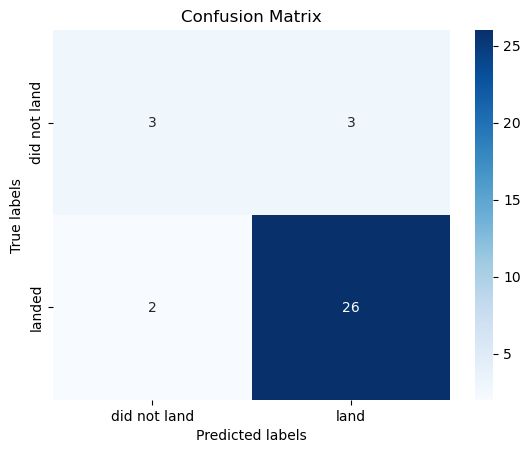

In [79]:
lr=LogisticRegression(random_state=2)

parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'], # l1 lasso l2 ridge
             'solver':['lbfgs']}
logreg_cv=GridSearchCV(lr,
                       param_grid=parameters,
                       cv=10)

logreg_cv.fit(X_train,Y_train)

logreg_score=logreg_cv.score(X_test,Y_test)

yhat=logreg_cv.predict(X_test)

logreg_f1=f1_score(Y_test,yhat)
logreg_proba=logreg_cv.predict_proba(X_test)[:,1]
logreg_auc=roc_auc_score(Y_test,logreg_proba)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_,'\n')
print("accuracy :",f"{logreg_cv.best_score_:.3f}",'\n')
print("Test Score :",f"{logreg_score:.3f}",'\n')
plot_confusion_matrix(Y_test,yhat)

**Support Vector Machine model**

tuned hpyerparameters :(best parameters)  {'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'} 

accuracy : 0.918 

Test Score : 0.853 



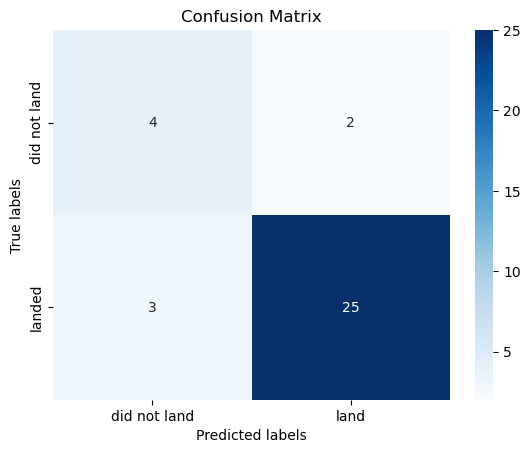

In [80]:
svm = SVC(probability=True,random_state=2)
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

svm_cv=GridSearchCV(svm,
                    cv=10,
                    param_grid=parameters)
svm_cv.fit(X_train,Y_train)

svm_score=svm_cv.score(X_test,Y_test)

yhat=svm_cv.predict(X_test)

svm_f1=f1_score(Y_test,yhat)

svm_proba=svm_cv.predict_proba(X_test)[:,1]
svm_auc=roc_auc_score(Y_test,svm_proba)

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_,'\n')
print("accuracy :",f"{svm_cv.best_score_:.3f}",'\n')
print("Test Score :",f"{svm_score:.3f}",'\n')
plot_confusion_matrix(Y_test,yhat)

**Decision Tree Classifier model**

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'} 

accuracy : 0.926 

Test Score : 0.853 



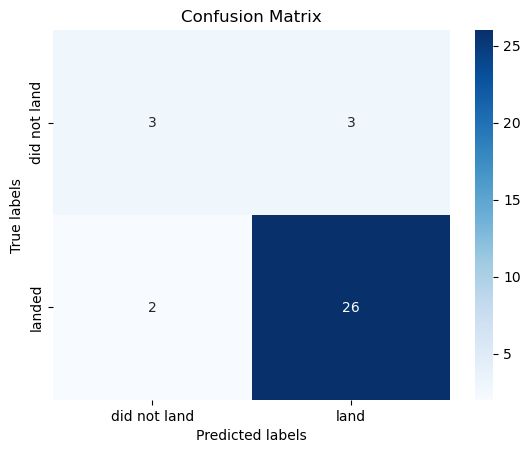

In [81]:
tree = DecisionTreeClassifier(random_state=2)
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree_cv=GridSearchCV(tree,
                    cv=10,
                    param_grid=parameters)
tree_cv.fit(X_train,Y_train)

tree_score=tree_cv.score(X_test,Y_test)

yhat=tree_cv.predict(X_test)

tree_f1=f1_score(Y_test,yhat)

tree_proba=tree_cv.predict_proba(X_test)[:,1]
tree_auc=roc_auc_score(Y_test,tree_proba)

print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_,'\n')
print("accuracy :",f"{tree_cv.best_score_:.3f}",'\n')
print("Test Score :",f"{tree_score:.3f}",'\n')
plot_confusion_matrix(Y_test,yhat)

**K Nearest Neighbour model**

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1} 

accuracy : 0.903 

Test Score : 0.882 



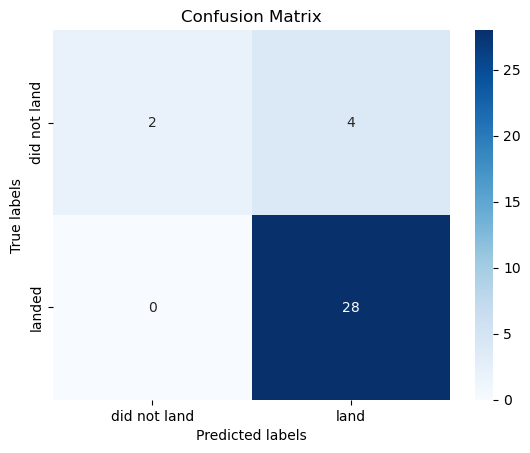

In [82]:
KNN = KNeighborsClassifier()
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn_cv=GridSearchCV(KNN,
                    cv=10,
                    param_grid=parameters)
knn_cv.fit(X_train,Y_train)

knn_score=knn_cv.score(X_test,Y_test)

yhat=knn_cv.predict(X_test)

knn_f1=f1_score(Y_test,yhat)

knn_proba=knn_cv.predict_proba(X_test)[:,1]
knn_auc=roc_auc_score(Y_test,knn_proba)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_,'\n')
print("accuracy :",f"{knn_cv.best_score_:.3f}",'\n')
print("Test Score :",f"{knn_score:.3f}",'\n')
plot_confusion_matrix(Y_test,yhat)

In [83]:
Data=pd.DataFrame({'Model':['LR','SVM','DT','KNN'],
              'F1 Score':[logreg_f1,svm_f1,tree_f1,knn_f1],
              'AUC':[logreg_auc,svm_auc,tree_auc,knn_auc],
              'Accuracy Test Score':[logreg_score,svm_score,tree_score,knn_score]
             }
            )
Data

,Model,F1 Score,AUC,Accuracy Test Score
0,LR,0.912281,0.904762,0.852941
1,SVM,0.909091,0.928571,0.852941
2,DT,0.912281,0.773810,0.852941
3,KNN,0.933333,0.773810,0.882353


In [84]:
# Reshape the data for the bar plot
Data2 = Data.melt(id_vars='Model', var_name='Metric', value_name='Score')
Data2

,Model,Metric,Score
0,LR,F1 Score,0.912281
1,SVM,F1 Score,0.909091
2,DT,F1 Score,0.912281
3,KNN,F1 Score,0.933333
4,LR,AUC,0.904762
5,SVM,AUC,0.928571
6,DT,AUC,0.773810
7,KNN,AUC,0.773810
8,LR,Accuracy Test Score,0.852941
9,SVM,Accuracy Test Score,0.852941


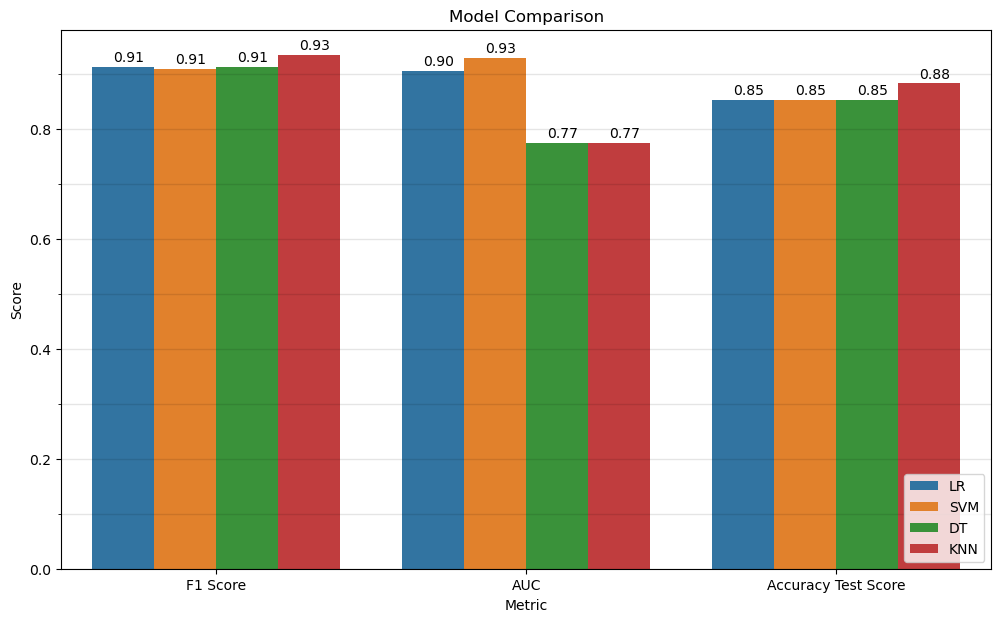

In [85]:
# Create the bar plot
plt.figure(figsize=(12,7))
ax=sns.barplot(data=Data2, x='Metric', y='Score', hue='Model')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',(p.get_x()+p.get_width()/3,p.get_height()+p.get_width()/20))
ax.yaxis.grid(which='both',linestyle='-',linewidth=1,color='black',alpha=0.1)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.legend(loc='lower right')
plt.title('Model Comparison')
plt.show()

**From the above models, K Nearest Neighbour is the best model.**

## Authors

[Alok Ranjan](https://www.linkedin.com/in/alokranjan-in/)